In [ ]:
import zipfile
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Signs project

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_path = '/content/drive/MyDrive/PATH_TO_poses.zip'
extraction_path = './'

 # Maximum number of JSON files to extract

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Get a list of all files in the zip archive
    all_files = zip_ref.namelist()

    # Filter out the list to include only JSON files
    json_files = [f for f in all_files if f.endswith('.json')]

    # Limit the number of files to extract to max_files
    files_to_extract = json_files

    # Extract only the selected files
    for file in files_to_extract:
        zip_ref.extract(file, extraction_path)

# List the contents of the extracted directory to verify
extracted_files = os.listdir(extraction_path)
print("Extracted files:", len(extracted_files))  # This may include non-JSON files already present in the directory


Extracted files: 4


In [ ]:
out_folder_path = './out'

# List all files in the "out" folder
files = os.listdir(out_folder_path)

# Filter out JSON files
json_files = [file for file in files if file.endswith('.json')]

In [ ]:
df = pd.read_csv('/content/drive/PATH_TO_modified_dataset_without_flata_händer_mot_varandra.csv')
df['names']

0         skolkurator-12712-tecken.json
1         skolkurator-12712-tecken.json
2            lillslam-10942-tecken.json
3           flaskhals-17136-tecken.json
4           flaskhals-17136-tecken.json
                      ...              
27618    utropstecken-15811-tecken.json
27619      avslutning-14198-tecken.json
27620      avslutning-14198-tecken.json
27621    liggunderlag-24845-tecken.json
27622    liggunderlag-24845-tecken.json
Name: names, Length: 27623, dtype: object

In [ ]:
  # Check if the required columns exist
if 'phonetics' in df.columns:
    # Create a mask for each condition
    condition_1 = df['phonetics'].str.contains('hög_positionering')
    condition_2 = df['phonetics'].str.contains('fingerpek_mot_handflata')
    condition_3 = df['phonetics'].str.contains('handflator_orienterade_inåt')

    # Apply conditions to get the indices of rows to modify
    indices_to_modify = condition_1 | condition_2 | condition_3

    # Update the values based on conditions
    df.loc[indices_to_modify, 'phonetics'] = (
        df.loc[indices_to_modify, 'phonetics']
        .apply(lambda x: ', '.join([e for e in x.split(', ') if e not in
                                    ['hög_positionering', 'fingerpek_mot_handflata',
                                     'handflator_orienterade_inåt']]))
    )

    # Remove rows where 'phonetics' becomes empty after removing the specified elements
    df = df[df['phonetics'] != '']
    df.reset_index(drop=True, inplace=True)


In [ ]:
import os
import json

# Assuming json_files is a list of filenames and out_folder_path is defined
subset = []  # List to hold the subset of data
 # Count for how many times we've found a matching file

for json_file in df['names'][0:1000]:  # Assuming you want to search the entire list but stop at 5 matches  # Check if "fraser" is in the file name
        json_path = os.path.join(out_folder_path, json_file)
        subset.append(json_path)
        with open(json_path, 'r') as file:
            data = json.load(file)
            # Add the loaded data to the subset list

 # Stop after finding 5 occurrences

# Now, `subset` contains data from the files that match the criteria





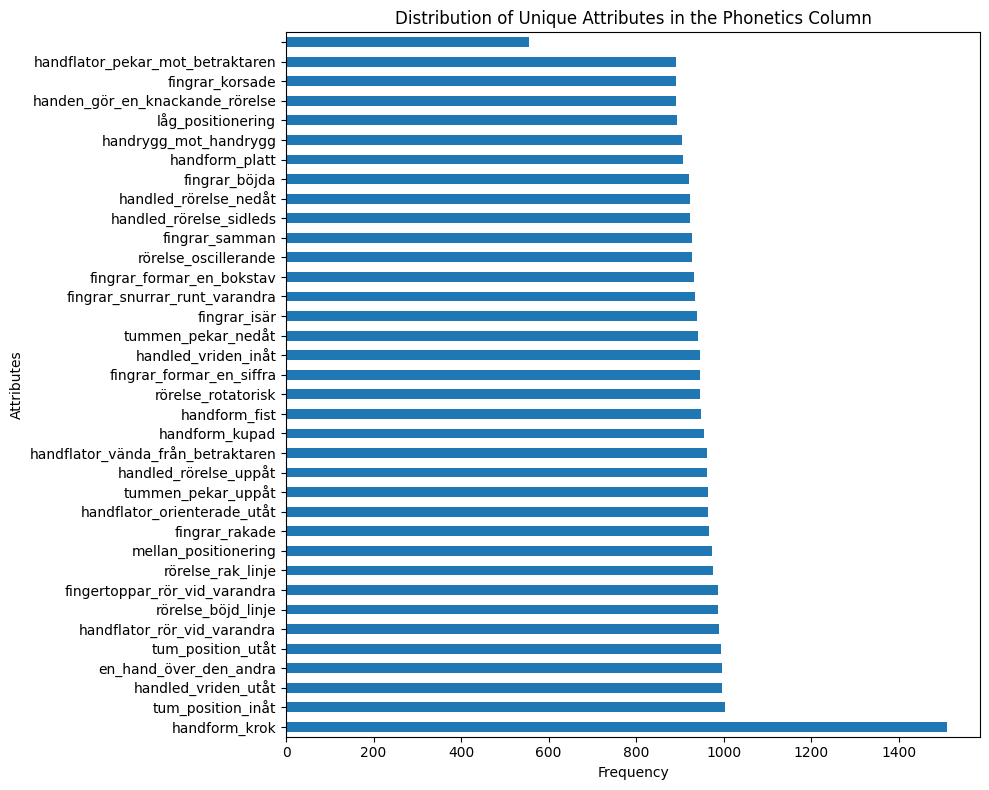

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame and 'phonetics' is the column of interest
# Step 1: Create a Series of individual attributes
attributes_series = df['phonetics'].str.split(', ').explode()

# Step 2: Count the occurrences of each unique attribute
attributes_counts = attributes_series.value_counts()

# Step 3: Plot the distribution of attributes
plt.figure(figsize=(10, 8)) # Adjust the figure size as needed
attributes_counts.plot(kind='barh') # Using a horizontal bar chart
plt.xlabel('Frequency')
plt.ylabel('Attributes')
plt.title('Distribution of Unique Attributes in the Phonetics Column')
plt.tight_layout() # Adjust the layout to make sure everything fits without overlap
plt.show()

In [ ]:
np.unique(attributes_series).shape


(36,)

In [ ]:
import torch
import json
import torch.nn.functional as F

hands_list_flattened = []
labels = []  # Assuming you have a corresponding label for each video

# Define the range of frames to include
start_frame = 0
end_frame = 200
frame_range = end_frame - start_frame
i = 0

for s in subset:
    with open(s, 'r') as file:
        data = json.load(file)

        video_hands_flattened = []
        for frame_key in sorted(data.keys()):
            if 'frame' in frame_key:
                frame_number = int(frame_key.split('_')[-1])
                if start_frame <= frame_number < end_frame:
                    frame_hands = data[frame_key]['hands']
                    frame_hands_flattened = torch.flatten(torch.tensor(frame_hands, dtype=torch.float))
                    video_hands_flattened.append(frame_hands_flattened)
                elif frame_number >= end_frame:
                    break  # Stop processing if beyond the end_frame

        # Determine the padding required to match the frame_range
        pad_size = frame_range - len(video_hands_flattened)
        if pad_size > 0:
            # If padding is needed, pad the sequence with zeros
            video_hands_flattened_tensor = F.pad(torch.stack(video_hands_flattened, dim=0), (0, 0, 0, pad_size), "constant", 0)
        else:
            # Otherwise, just stack the tensors
            video_hands_flattened_tensor = torch.stack(video_hands_flattened, dim=0)

        hands_list_flattened.append(video_hands_flattened_tensor)
        labels.append(df['phonetics'][i])
        i += 1




In [ ]:
# Assuming `labels` is a list where each element is a string of comma-separated labels
labels_corrected = [label.split(", ") for label in labels]
print(labels_corrected)
"""
for i in range(len(labels_corrected)):
    print(labels_corrected[i])

"""
len(labels_corrected)

[['handled_vriden_inåt'], ['handform_krok'], ['handform_krok'], ['handflator_orienterade_utåt', 'tummen_pekar_nedåt'], ['fingrar_snurrar_runt_varandra', 'handform_krok'], ['handled_rörelse_nedåt', 'tummen_pekar_uppåt'], ['fingrar_korsade', 'en_hand_över_den_andra'], ['fingrar_snurrar_runt_varandra', 'fingrar_samman'], ['tummen_pekar_nedåt'], ['tum_position_utåt'], ['handrygg_mot_handrygg', 'fingrar_formar_en_bokstav'], ['handled_rörelse_uppåt', 'handform_fist'], ['fingrar_rakade', 'fingrar_böjda'], ['handled_vriden_utåt'], ['handflator_rör_vid_varandra', 'handen_gör_en_knackande_rörelse'], ['rörelse_oscillerande', 'handflator_vända_från_betraktaren'], ['handled_rörelse_uppåt'], ['fingertoppar_rör_vid_varandra'], ['tum_position_inåt'], ['rörelse_rotatorisk', 'handled_rörelse_sidleds'], ['tummen_pekar_uppåt'], ['fingrar_korsade'], ['handled_rörelse_sidleds', 'handled_vriden_inåt'], ['handflator_rör_vid_varandra', 'fingrar_böjda'], ['tum_position_utåt'], ['handflator_rör_vid_varandra'], [

1000

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
labels_encoded = mlb.fit_transform(labels_corrected)

# Now check the encoded results again
for i, (original_labels, encoded_labels) in enumerate(zip(labels_corrected, labels_encoded)):
    print(f"Original Labels for instance {i+1}: {original_labels}")
    print(f"Encoded Labels for instance {i+1}: {encoded_labels}")
    decoded_labels = mlb.inverse_transform(encoded_labels.reshape(1, -1))[0]
    print(f"Decoded Labels for instance {i+1}: {decoded_labels}\n")

    if i == 4:  # Limit to first 5 examples
        break


Original Labels for instance 1: ['handled_vriden_inåt']
Encoded Labels for instance 1: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Decoded Labels for instance 1: ('handled_vriden_inåt',)

Original Labels for instance 2: ['handform_krok']
Encoded Labels for instance 2: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Decoded Labels for instance 2: ('handform_krok',)

Original Labels for instance 3: ['handform_krok']
Encoded Labels for instance 3: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Decoded Labels for instance 3: ('handform_krok',)

Original Labels for instance 4: ['handflator_orienterade_utåt', 'tummen_pekar_nedåt']
Encoded Labels for instance 4: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
Decoded Labels for instance 4: ('handflator_orienterade_utåt', 'tummen_pekar_nedåt')

Original Labels for instance 5: ['fingrar_snurrar_runt_varandra', 'handform_krok']
Encoded La

In [ ]:
"""
For multi-label classification,
each label for an entry needs to be represented in a way that can
reflect the presence or absence of each possible class.
This is typically done using a one-hot encoded vector or a binary vector,
where each element corresponds to a possible class/output.
The element is set to 1 (or true) if the class is relevant for the entry, and 0 (or false)
otherwise.

Given your output vector, each label should be transformed into a vector
of the same length as the output vector, with binary indicators representing
the presence of each class.
"""


output_vector = [
    "låg_positionering",
    "mellan_positionering",
    #"hög_positionering",
    #"handflator_orienterade_inåt",
    "handflator_orienterade_utåt",
    "tum_position_inåt",
    "tum_position_utåt",
    "fingrar_samman",
    "fingrar_isär",
    "fingrar_rakade",
    "fingrar_böjda",
    "handform_krok",
    "handform_platt",
    "handform_kupad",
    "handform_fist",
    "rörelse_oscillerande",
    "rörelse_rotatorisk",
    "rörelse_rak_linje",
    "rörelse_böjd_linje",
    "handled_vriden_inåt",
    "handled_vriden_utåt",
    "handled_rörelse_uppåt",
    "handled_rörelse_nedåt",
    "handled_rörelse_sidleds",
    "fingertoppar_rör_vid_varandra",
    "fingrar_korsade",
    "handflator_rör_vid_varandra",
    "handrygg_mot_handrygg",
    "flata_händer_mot_varandra",
    "en_hand_över_den_andra",
    "fingrar_snurrar_runt_varandra",
    "tummen_pekar_uppåt",
    "tummen_pekar_nedåt",
    #"fingerpek_mot_handflata",
    "handflator_pekar_mot_betraktaren",
    "handflator_vända_från_betraktaren",
    "fingrar_formar_en_bokstav",
    "fingrar_formar_en_siffra",
    "handen_gör_en_knackande_rörelse"
     ]

print(len(output_vector))

36


In [ ]:
labels_encoded.shape

(1000, 36)

# Models

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class SignLanguageModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SignLanguageModel, self).__init__()
        self.hidden_size = hidden_size

        # RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)

        # Dense layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])

        return torch.sigmoid(out)  # Applying sigmoid to predict the presence/absence of each label

input_size = 84  # 21 x-coordinates and 21 y-coordinates
hidden_size = 64  # Can be tuned
output_size = 36  # Number of labels

model = SignLanguageModel(input_size, hidden_size, output_size)
print(model)

# Define loss and optimizer
loss_fn = nn.BCELoss() # Binary Cross-Entropy Loss for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


SignLanguageModel(
  (rnn): RNN(84, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=36, bias=True)
)


In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into training (70%) and temp (30% for further splitting)

train_data, temp_data, train_labels, temp_labels = train_test_split(hands_list_flattened, labels_encoded, test_size=0.3, random_state=42)

# Split the temp data into validation (2/3 of 30% => 20%) and test (1/3 of 30% => 10%)
val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=1/3, random_state=42)

print(f"Training Set Size: {len(train_data)}")
print(f"Validation Set Size: {len(val_data)}")
print(f"Test Set Size: {len(test_data)}")
print(f"Shape of train_labels: {train_labels.shape}")
# Assuming train_labels is a binary encoded matrix of shape (num_samples, num_labels)


print(len(train_data))



Training Set Size: 700
Validation Set Size: 200
Test Set Size: 100
Shape of train_labels: (700, 36)
700


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Convert lists or arrays to tensors
# Convert lists or arrays to tensors
train_data_tensor = torch.stack([torch.tensor(item, dtype=torch.float32).clone().detach() for item in train_data])
train_labels_tensor = torch.stack([torch.tensor(item, dtype=torch.float32).clone().detach() for item in train_labels])
val_data_tensor = torch.stack([torch.tensor(item, dtype=torch.float32).clone().detach() for item in val_data])
val_labels_tensor = torch.stack([torch.tensor(item, dtype=torch.float32).clone().detach() for item in val_labels])
test_data_tensor = torch.stack([torch.tensor(item, dtype=torch.float32).clone().detach() for item in test_data])
test_labels_tensor = torch.stack([torch.tensor(item, dtype=torch.float32).clone().detach() for item in test_labels])


# Create TensorDatasets
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_data_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


<ipython-input-50-f8825ea9e79c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data_tensor = torch.stack([torch.tensor(item, dtype=torch.float32).clone().detach() for item in train_data])
<ipython-input-50-f8825ea9e79c>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_data_tensor = torch.stack([torch.tensor(item, dtype=torch.float32).clone().detach() for item in val_data])
<ipython-input-50-f8825ea9e79c>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data_tensor = torch.stack([torch.tensor(item, dtype=torch.float32).clo

Epoch 1, Loss: 0.5442337217656049
Epoch 1, Validation Loss: 0.32479395610945566
Epoch 2, Loss: 0.23601933230053296
Epoch 2, Validation Loss: 0.1762019246816635
Epoch 3, Loss: 0.16996171325445175
Epoch 3, Validation Loss: 0.16796792617865972
Epoch 4, Loss: 0.1669639159332622
Epoch 4, Validation Loss: 0.16781622171401978
Epoch 5, Loss: 0.1669336801225489
Epoch 5, Validation Loss: 0.16799549332686833
Epoch 6, Loss: 0.16666815836321225
Epoch 6, Validation Loss: 0.1681962651865823
Epoch 7, Loss: 0.16681392152201047
Epoch 7, Validation Loss: 0.1680372016770499
Epoch 8, Loss: 0.1666976518251679
Epoch 8, Validation Loss: 0.16833695343562535
Epoch 9, Loss: 0.16676076637072998
Epoch 9, Validation Loss: 0.16816036190305436
Epoch 10, Loss: 0.16680563308975913
Epoch 10, Validation Loss: 0.168183656675475


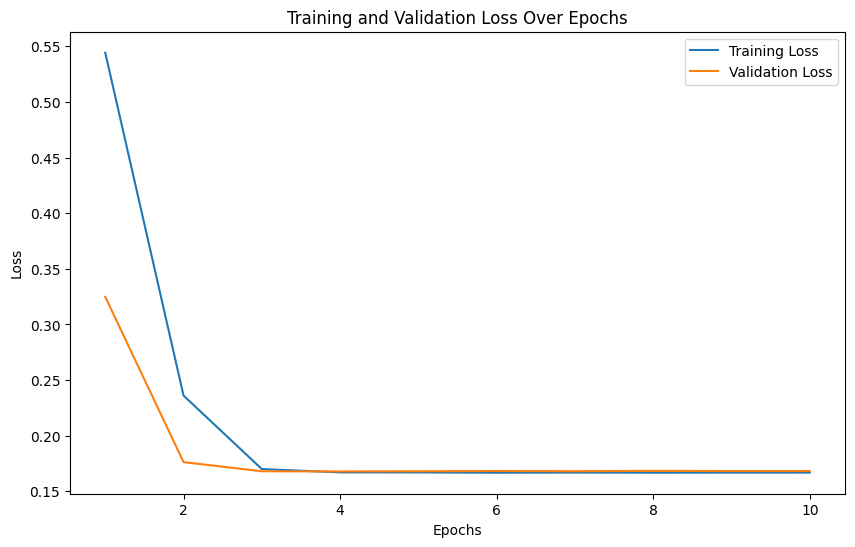

In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store loss values
training_losses = []
validation_losses = []

num_epochs = 10  # Adjust based on your needs
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Clear gradients
        outputs = model(inputs)  # Forward pass
        loss = loss_fn(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters

        total_loss += loss.item()
    avg_training_loss = total_loss / len(train_loader)
    training_losses.append(avg_training_loss)

    # Print average training loss per epoch
    print(f"Epoch {epoch+1}, Loss: {avg_training_loss}")

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
    avg_validation_loss = val_loss / len(val_loader)
    validation_losses.append(avg_validation_loss)

    # Print average validation loss per epoch
    print(f"Epoch {epoch+1}, Validation Loss: {avg_validation_loss}")

# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
# Set model to evaluation mode
model.eval()

# Initialize variables to store predictions
all_predictions = []

# Disable gradient calculation
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)

        # Thresholding outputs to get binary predictions
        predicted_labels = (outputs > 0.5).float()

        all_predictions.append(predicted_labels.numpy())

# Concatenate predictions
all_predictions = np.concatenate(all_predictions, axis=0)

# Count unique predictions
unique_predictions = np.unique(all_predictions, axis=0)

print(unique_predictions)

# Print the number of unique predictions
print(f"Number of unique predictions: {len(unique_predictions)}")




[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Number of unique predictions: 1


In [ ]:
# Set model to evaluation mode
model.eval()

# Initialize variables to store predictions
all_predictions = []
all_actual_labels = []

# Disable gradient calculation
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)

        # Thresholding outputs to get binary predictions
        predicted_labels = (outputs > 0.5).float()

        all_predictions.append(predicted_labels.numpy())
        all_actual_labels.append(labels.numpy())

# Concatenate predictions and actual labels
all_predictions = np.concatenate(all_predictions, axis=0)
all_actual_labels = np.concatenate(all_actual_labels, axis=0)

# Convert predictions and actual labels to lists of class indices
predicted_classes = [np.where(pred == 1)[0] for pred in all_predictions]
actual_classes = [np.where(label == 1)[0] for label in all_actual_labels]

# Print some predictions
for i in range(min(5, len(predicted_classes))):  # Print predictions for the first 5 samples
    print(f"Predicted Classes for instance {i+1}: {predicted_classes[i]}")
    print(f"Actual Classes for instance {i+1}: {actual_classes[i]}\n")


Predicted Classes for instance 1: []
Actual Classes for instance 1: [32 35]

Predicted Classes for instance 2: []
Actual Classes for instance 2: [10 13]

Predicted Classes for instance 3: []
Actual Classes for instance 3: [23]

Predicted Classes for instance 4: []
Actual Classes for instance 4: [11 15]

Predicted Classes for instance 5: []
Actual Classes for instance 5: [28]



In [ ]:
tuple(train_labels_tensor.shape)

(700, 36)

# Second model

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard
from keras.losses import SparseCategoricalCrossentropy
import os

# LSTM model to perform sign classification given key positions

class SignClassifier(keras.Model) :
    def __init__(self, input_shape, output_shape, epochs):
        """
        Initializes the SignClassifier object.

        Args:
            input_shape (tuple): The shape of the input data (nb_frames, frame_features_nb)
            output_shape (tuple): The shape of the output data (class_nb,)
            epochs (int): The number of epochs to train the model. Recommended : 2000

        Returns:
            None
        """

        super(SignClassifier, self).__init__()

        # Parameters of the model
        self.input_shpe = input_shape
        self.output_shpe = output_shape
        self.log_dir = os.path.join('logs')
        self.tb_callback = TensorBoard(log_dir=self.log_dir)
        self.epochs = epochs

        # Building model
        self.build_model()

    def build_model(self) :
        self.model = Sequential()

        # From one LSTM layer to another, the output is used as input of the next one
        self.model.add(LSTM(64, activation='relu', return_sequences = True, input_shape = self.input_shpe))
        self.model.add(LSTM(128, activation='relu', return_sequences = True))
        self.model.add(LSTM(64, activation='relu', return_sequences = False))

        # Now, we keep the values of the short-memory and long-memory to perform classification
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(32, activation='relu'))

        # Finally adding the output layer
        self.model.add(Dense(self.output_shpe, activation='sigmoid'))

        # Compiling the model
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])

    def fit(self, X_train, Y_train, X_val=None, Y_val=None) :
        if X_val != None :
            self.model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=self.epochs, callbacks=[self.tb_callback])
        else :
            self.model.fit(X_train, Y_train, epochs=self.epochs, callbacks=[self.tb_callback])
    def predict(self, X) :
        return self.model.predict(X)

In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into training (70%) and temp (30% for further splitting)

train_data, temp_data, train_labels, temp_labels = train_test_split(hands_list_flattened, labels_encoded, test_size=0.3, random_state=42)

# Split the temp data into validation (2/3 of 30% => 20%) and test (1/3 of 30% => 10%)
val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=1/3, random_state=42)

print(f"Training Set Size: {len(train_data)}")
print(f"Validation Set Size: {len(val_data)}")
print(f"Test Set Size: {len(test_data)}")
print(f"Shape of train_labels: {train_labels.shape}")
# Assuming train_labels is a binary encoded matrix of shape (num_samples, num_labels)

# Converting in array nump
train_data = np.array(train_data)
val_data = np.array(val_data)
test_data = np.array(test_data)
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

Training Set Size: 700
Validation Set Size: 200
Test Set Size: 100
Shape of train_labels: (700, 36)


In [ ]:
import numpy as np
sign_classifier2 = SignClassifier(tuple(train_data_tensor.shape[1:]), train_labels.shape[1], 40)
sign_classifier2.fit(X_train = train_data, Y_train = train_labels)

Epoch 1/40
22/22 [==============================] - 20s 633ms/step - loss: 248.1031 - categorical_accuracy: 0.0243
Epoch 2/40
22/22 [==============================] - 14s 638ms/step - loss: nan - categorical_accuracy: 0.0214
Epoch 3/40
22/22 [==============================] - 14s 634ms/step - loss: nan - categorical_accuracy: 0.0200
Epoch 4/40
22/22 [==============================] - 14s 634ms/step - loss: nan - categorical_accuracy: 0.0200
Epoch 5/40
22/22 [==============================] - 14s 638ms/step - loss: nan - categorical_accuracy: 0.0200
Epoch 6/40
22/22 [==============================] - 14s 629ms/step - loss: nan - categorical_accuracy: 0.0200
Epoch 7/40
22/22 [==============================] - 16s 717ms/step - loss: nan - categorical_accuracy: 0.0200
Epoch 8/40
12/22 [===============>..............] - ETA: 11s - loss: nan - categorical_accuracy: 0.0104

In [ ]:
predicted_distrib = sign_classifier2.predict(train_data)

In [ ]:
print(np.argmax(predicted_distrib,axis=1))
threshold = 0.14
predicted_labels = np.where(predicted_distrib >= threshold, 1, 0)

In [ ]:
indexes_where_1 = [np.where(row == 1)[0] for row in predicted_labels]


In [ ]:
print(np.argmax(train_labels, axis = 1).shape)